### Exercise 1 Data based modeling and control

#### Imports

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from control.matlab import tf, step, lsim


from utils import dbm_math



%matplotlib inline

#### Loading Matlab data 

In [2]:
mat_1 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data2_step.mat")
mat_2 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data1_step.mat")

for k in mat_1.keys():
    print(k)

for k in mat_2.keys():
    print(k)

__header__
__version__
__globals__
t2
u2
y2
__header__
__version__
__globals__
None
p
t
u
y
__function_workspace__


#### First look at data

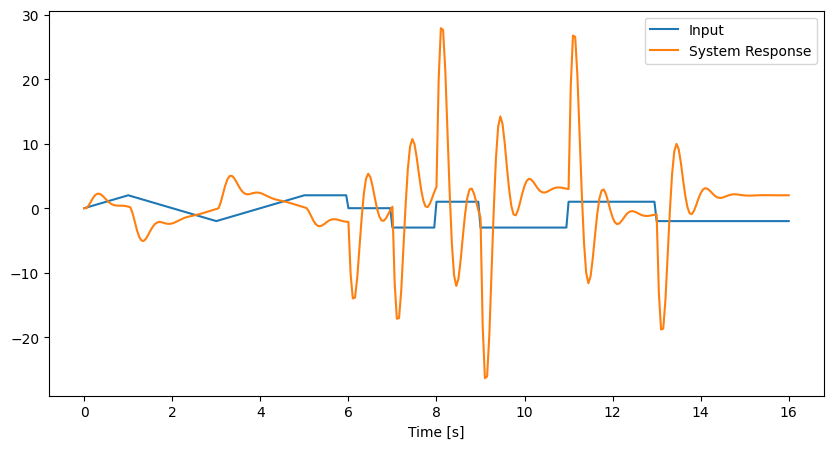

In [3]:
t2 = [e[0] for e in mat_1.get("t2").T]
u2 = [e[0] for e in mat_1.get("u2")]
y2 = [e[0] for e in mat_1.get("y2")]

plt.figure(figsize=(10, 5))
plt.plot(t2,u2, label="Input")
plt.xlabel("Time [s]")
plt.plot(t2, y2,label="System Response")
plt.legend()
plt.show()




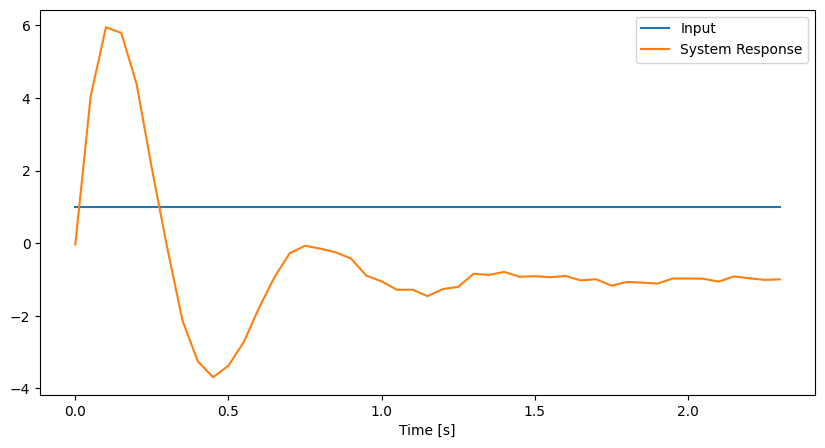

In [4]:
p = mat_2.get("p")
t = [e[0] for e in mat_2.get("t")]
u = [e[0] for e in mat_2.get("u")]
y = [e[0] for e in mat_2.get("y")]

plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()

#### Declaring constants

In [5]:
# Constants
Ts = 0.05
NA = 4
NB = 4

#### Creation of Model

In [6]:
def s_k(y:np.array,u:np.array,n_a,n_b, k):
    """ Construct the s_k vector
    
    Args:
        y (np.array): Output vector
        u (np.array): Input vector
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
    
    Returns:
        np.array: s_k vector
    """
    
    s_a = list(np.zeros(n_a))
    s_b = list(np.zeros(n_b +1))
    
    for i in range(k+1):
        index_a:int = k - i -1

        index_b:int = k - i

        if index_a >= 0:
            try:
                s_a[index_a] = float(y[i])
            except Exception:
                pass
        if index_b >= 0:
            try:
                s_b[index_b] = float(u[i])
            except Exception as e:
                pass
    
    s = s_a + s_b
    return s


S_K = [s_k(y,u,NA,NB,k) for k in range(len(y))]

SU = np.array([s_k(y2,u2, NA, NB, k) for k in range(len(y2))])

S_K = np.array(S_K)


In [7]:
y_jax = jnp.array(y)
u_jax = jnp.array(u)
y2_jax = jnp.array(y2)
u2_jax = jnp.array(u2)
S_K_3 = dbm_math.data_matrix(y_jax, u_jax, NA, NB)
SU2 = dbm_math.data_matrix(y2_jax, u2_jax, NA, NB)


In [8]:
p_hat = np.matmul(np.linalg.pinv(S_K),y)

p_hat:jax.Array = jnp.matmul(jnp.linalg.pinv(S_K_3),jnp.array(y))

In [16]:
Gest = tf(p_hat[NA:].tolist(), [1] + list([-e for e  in p_hat[:NA].tolist()]), Ts)

y_test, test = step(Gest, T=t)
y_out, _, x_out = lsim(Gest, u2, T=t2)

print(Gest)

<TransferFunction>: sys[15]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-0.0397 z^4 + 4.102 z^3 - 0.1747 z^2 - 3.492 z - 0.8735
-------------------------------------------------------
   z^4 - 0.5153 z^3 - 0.5726 z^2 + 0.3858 z + 0.1783

dt = 0.05



/home/matthias/miniconda3/envs/python3.13/lib/python3.13/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


#### Plot Results of step response

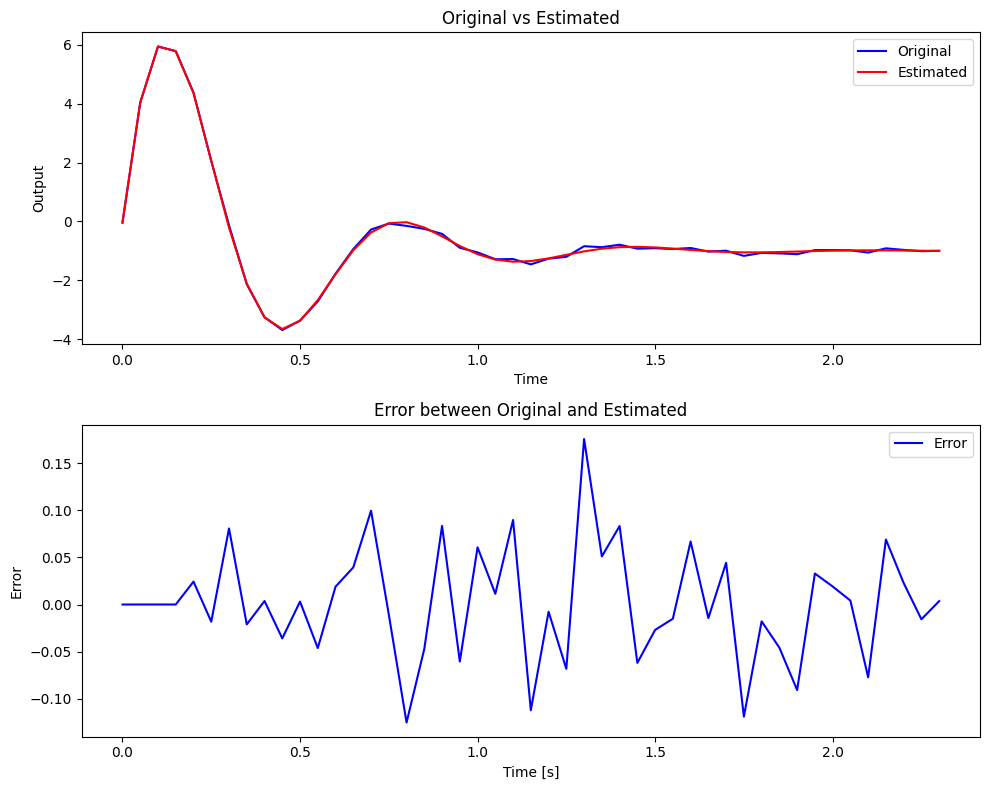

In [10]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))

ax[0].plot(t, y, 'b-', label='Original')
ax[0].plot(t, y_test, 'r-', label='Estimated')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Output')
ax[0].set_title('Original vs Estimated')

ax[1].plot(t, (y - y_test), 'b-', label='Error')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Error')
ax[1].set_title('Error between Original and Estimated')
plt.tight_layout()
plt.show()

#### Plot results of validation set

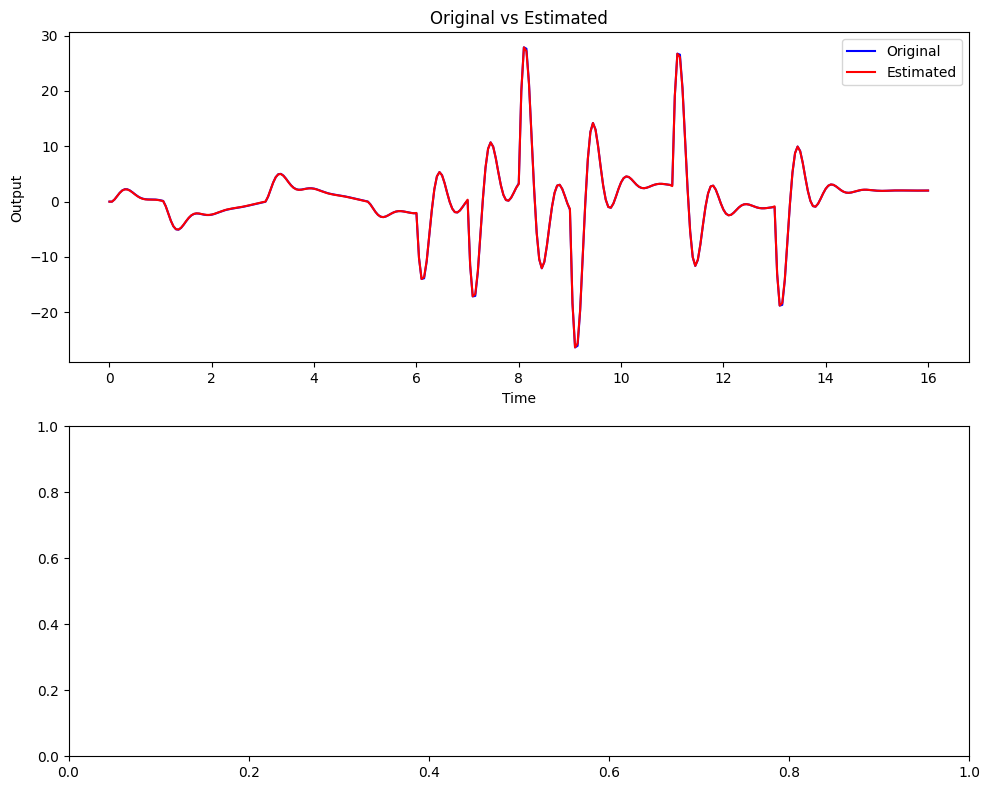

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(t2, y2, 'b-', label='Original')
axs[0].plot(t2, y_out, 'r-', label='Estimated')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Output')
axs[0].set_title('Original vs Estimated')


plt.tight_layout()
plt.show()